<a href="https://colab.research.google.com/github/kundajelab/pho4/blob/master/AnalyzeTrainedPho4Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
![[ -f peaks1.bed ]] || wget http://mitra.stanford.edu/kundaje/eileenli/SRR5179199.1x36mers.unique.MACS-2.1.0.shift75_extsize150_peaks.narrowPeak -O peaks1.bed
![[ -f peaks2.bed ]] || wget http://mitra.stanford.edu/kundaje/eileenli/SRR5179200.1x36mers.unique.MACS-2.1.0.shift75_extsize150_peaks.narrowPeak -O peaks2.bed

!cat peaks1.bed peaks2.bed > peaks.bed
  
![[ -f peaks.bed.gz ]] || gzip peaks.bed
  
#Get hg38 fasta by download 2bit and then converting to fa
![[ -f sacCer3.2bit ]] || wget http://hgdownload.cse.ucsc.edu/goldenPath/sacCer3/bigZips/sacCer3.2bit -O sacCer3.2bit  

In [0]:
![[ -f twoBitToFa ]] || wget http://hgdownload.soe.ucsc.edu/admin/exe/linux.x86_64/twoBitToFa -O twoBitToFa
!chmod a+x twoBitToFa

In [0]:
![[ -f sacCer3.genome.fa ]] || ./twoBitToFa sacCer3.2bit sacCer3.genome.fa

In [0]:
![[ -f sacCer3.chrom.sizes ]] || wget http://hgdownload.cse.ucsc.edu/goldenPath/sacCer3/bigZips/sacCer3.chrom.sizes -O sacCer3.chrom.sizes

In [56]:
!apt-get install bedtools
!pip install pyfaidx
!pip install pyBigWig

Reading package lists... Done
Building dependency tree       
Reading state information... Done
bedtools is already the newest version (2.26.0+dfsg-5).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.


In [0]:
#get 1kb around summits
![[ -f 1k_around_summits.bed.gz ]] || zcat peaks.bed.gz | perl -lane 'print $F[0]."\t".(($F[1]+$F[9]))."\t".(($F[1]+$F[9]))' | bedtools slop -g sacCer3.chrom.sizes -b 500 | perl -lane 'if ($F[2]-$F[1]==1000) {print $F[0]."\t".$F[1]."\t".$F[2]."\t1"}' | sortBed | gzip -c > 1k_around_summits.bed.gz
#split into train, valid, test sets
![[ -f test_1k_around_summits.bed.gz ]] || zcat 1k_around_summits.bed.gz | egrep -w 'chrX|chrXI' | gzip -c > test_1k_around_summits.bed.gz
![[ -f valid_1k_around_summits.bed.gz ]] || zcat 1k_around_summits.bed.gz | egrep -w 'chrXIV|chrVIII' | gzip -c > valid_1k_around_summits.bed.gz
![[ -f train_1k_around_summits.bed.gz ]] || zcat 1k_around_summits.bed.gz | egrep -w -v 'chrX|chrXI|chrXIV|chrVIII|chrM' | gzip -c > train_1k_around_summits.bed.gz

In [58]:
%cd /content
![[ -f samtools-1.9.tar.bz2 ]] || wget https://github.com/samtools/samtools/releases/download/1.9/samtools-1.9.tar.bz2
!tar -xjf samtools-1.9.tar.bz2
%cd samtools-1.9
!./configure
!make
!make install
%cd ..

/content
/content/samtools-1.9
checking for gcc... gcc
checking whether the C compiler works... yes
checking for C compiler default output file name... a.out
checking for suffix of executables... 
checking whether we are cross compiling... no
checking for suffix of object files... o
checking whether we are using the GNU C compiler... yes
checking whether gcc accepts -g... yes
checking for gcc option to accept ISO C89... none needed
checking for special C compiler options needed for large files... no
checking for _FILE_OFFSET_BITS value needed for large files... no
checking location of HTSlib source tree... htslib-1.9
checking for NcursesW wide-character library... no
checking for Ncurses library... yes
checking for working ncurses/curses.h... no
checking for working ncurses.h... yes
checking for zlib.h... yes
checking for inflate in -lz... yes
checking for library containing regcomp... none required
configure: creating ./config.status
config.status: creating config.mk
config.status: cr

In [0]:
#make index
![[ -e sacCer3.genome.fa.fai ]] || samtools faidx sacCer3.genome.fa

In [0]:
! [[ -f pos_strand1.bw ]] || wget http://mitra.stanford.edu/kundaje/eileenli/SRR5179199.1x36mers.unique.5p.counts.plus.bigWig -O pos_strand1.bw
! [[ -f neg_strand1.bw ]] || wget http://mitra.stanford.edu/kundaje/eileenli/SRR5179199.1x36mers.unique.5p.counts.minus.bigWig -O neg_strand1.bw

! [[ -f pos_strand2.bw ]] || wget http://mitra.stanford.edu/kundaje/eileenli/SRR5179200.1x36mers.unique.5p.counts.plus.bigWig -O pos_strand2.bw
! [[ -f neg_strand2.bw ]] || wget http://mitra.stanford.edu/kundaje/eileenli/SRR5179200.1x36mers.unique.5p.counts.minus.bigWig -O neg_strand2.bw
  
! [[ -f control_pos_strand.bw ]] || wget http://mitra.stanford.edu/kundaje/eileenli/SRR5179234.1x36mers.unique.5p.counts.plus.bigWig -O control_pos_strand.bw
! [[ -f control_neg_strand.bw ]] || wget http://mitra.stanford.edu/kundaje/eileenli/SRR5179234.1x36mers.unique.5p.counts.minus.bigWig -O control_neg_strand.bw

In [61]:
!wget http://hgdownload.soe.ucsc.edu/admin/exe/linux.x86_64/bedGraphToBigWig -O bedGraphToBigWig
!chmod a+x bedGraphToBigWig

--2019-06-21 23:20:22--  http://hgdownload.soe.ucsc.edu/admin/exe/linux.x86_64/bedGraphToBigWig
Resolving hgdownload.soe.ucsc.edu (hgdownload.soe.ucsc.edu)... 128.114.119.163
Connecting to hgdownload.soe.ucsc.edu (hgdownload.soe.ucsc.edu)|128.114.119.163|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5167104 (4.9M) [text/plain]
Saving to: ‘bedGraphToBigWig’

bedGraphToBigWig    100%[===================>]   4.93M   996KB/s    in 6.6s    

2019-06-21 23:20:29 (763 KB/s) - ‘bedGraphToBigWig’ saved [5167104/5167104]



In [62]:
!wget http://hgdownload.soe.ucsc.edu/admin/exe/linux.x86_64/bigWigMerge -O bigWigMerge
!chmod a+x bigWigMerge

--2019-06-21 23:20:31--  http://hgdownload.soe.ucsc.edu/admin/exe/linux.x86_64/bigWigMerge
Resolving hgdownload.soe.ucsc.edu (hgdownload.soe.ucsc.edu)... 128.114.119.163
Connecting to hgdownload.soe.ucsc.edu (hgdownload.soe.ucsc.edu)|128.114.119.163|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5172184 (4.9M) [text/plain]
Saving to: ‘bigWigMerge’

bigWigMerge         100%[===================>]   4.93M   990KB/s    in 6.8s    

2019-06-21 23:20:38 (739 KB/s) - ‘bigWigMerge’ saved [5172184/5172184]



In [0]:
![[ -f positive_strand.bedGraph ]] || ./bigWigMerge pos_strand1.bw pos_strand2.bw positive_strand.bedGraph

In [0]:
![[ -f pos_strand.bw ]] || ./bedGraphToBigWig positive_strand.bedGraph sacCer3.chrom.sizes pos_strand.bw

In [0]:
!touch neg_strand.bw

In [0]:
import pyBigWig
from itertools import *

def customSort(val):
      chrom_number = "".join(takewhile(str.isalpha,val[0]))
      start = val[0].replace(chrom_number,"")
      return int(start)

# Data loader that accepts multiple replicates and adds them together
    
class DataLoader(object):
    
    def __init__(self, replicates):
        """
        Args:
            replicates (list of bigwig files)
        """
        self.replicates = replicates
    
    def merge(self):
      bigWigs = []
      # bw_pos1.chroms() - remember to save the chromosomes dict into a variable
      # num_chroms = 16 # don't need this anymore b/c length of chromosomes dict
      
      # opening bw files.
      for idx in range(len(self.replicates)):
        bigWigs.append(pyBigWig.open(self.replicates[idx]))
        
      chrms = ["chrI","chrII","chrIII","chrIV","chrV","chrVI","chrVII","chrVIII",
               "chrIX","chrX","chrXI","chrXII","chrXIII","chrXIV","chrXV","chrXVI"]
        
      # retrieve values. save to new array, then save that to new bw file.
      combined_dict = {}
      for c in chrms:
        for j in range(len(bigWigs)):
          intervals = bigWigs[j].intervals(c)
          for i in intervals:
            start = i[0]
            end = i[1]
            val = i[2]
            for k in range(start,end):
              if (c+str(start)) in combined_dict:
                combined_dict[c+str(start)]+=val
              else:
                combined_dict[c+str(start)]=val
      
      # sort combined_dict
      # SORT EACH CHROMOSOME AT A TIME, THEN ADD TO DICTIONARY
      sorted_dict = {}
      flag = True
      chrom_list = []
      prev_chrom_num = ""

      for key in combined_dict:
        chrom_number = "".join(takewhile(str.isalpha,key))
        if (flag or chrom_number==prev_chrom_num):
          chrom_list.append((key,combined_dict[key]))
        else:
          chrom_list.sort(key=customSort)
          # append to new dictionary
          # code here:
          for entry in chrom_list:
            sorted_dict[entry[0]]=entry[1]
          chrom_list = []
          chrom_list.append((key,combined_dict[key]))
        flag = False
        prev_chrom_num=chrom_number
   
      
      # sorted_dict format
      """
      Key: chrom number + start, ex: "chrI324"
      Value: the sum of the values in the bigwig files
      """
      return sorted_dict 
    
    def getChromNums(self):
      # get an ordered list of the chromosome numbers
      ch_num = []
      for key in self.merge():
          chrom_number = "".join(takewhile(str.isalpha,key))
          ch_num.append(chrom_number)
      return np.array(ch_num)
    
    def getChromStart(self):
      # get an ordered list of the chromosome start positions
      ch_start = []
      for key in self.merge():
        chrom_number = "".join(takewhile(str.isalpha,key))
        start = key.replace(chrom_number,"")
        ch_start.append(int(start))
      return np.array(ch_start)
    
    def getChromEnd(self):
      # get an ordered list of the chromosome end positions. 1 base pair long so end pos is 1 more than start.
      ch_end = []
      for entry in self.getChromStart():
        ch_end.append(entry+1)
      return np.array(ch_end)
    
    def getChromVals(self):
      # get an ordered list of the chromosome values.
      ch_vals = []
      vals_dict = self.merge() 
      for key in vals_dict:
        ch_vals.append(vals_dict[key])
      return np.array(ch_vals)
       
        

In [0]:
import pyBigWig
data_loader = DataLoader(["neg_strand1.bw","neg_strand2.bw"])
data_loader.merge();

In [0]:
neg_bw = pyBigWig.open("neg_strand.bw","w")

In [0]:
neg_bw.addHeader([("chrI",230218),("chrII",813184),("chrIII",316620),("chrIV",1531933),("chrV",576874),("chrVI",270161),("chrVII",1090940),("chrVIII",562643),("chrIX",439888),("chrX",745751),("chrXI",666816),("chrXII",1078177),("chrXIII",924431),("chrXIV",784333),("chrXV",1091291),("chrXVI",948066)])

In [0]:
import numpy as np

In [0]:
neg_bw.addEntries(data_loader.getChromNums(),data_loader.getChromStart(),ends=data_loader.getChromEnd(),values=data_loader.getChromVals())

In [0]:
neg_bw.close()

In [0]:
n_bw = pyBigWig.open("neg_strand.bw",'r')

In [0]:
n_bw.intervals("chrX");

In [0]:
import numpy as np
from pyfaidx import Fasta
import pyBigWig
import gzip
import keras


class Coordinates(object):
    
    def __init__(self, chrom, start, end, isplusstrand=True):
        """
        Args:
            chrom (string)
            start (int)
            end (int)
            isplusstrand (boolean, optional): default True
            
        """
        self.chrom = chrom
        self.start = start
        self.end = end
        self.isplusstrand = isplusstrand
    
    def __str__(self):
       return (self.chrom+":"+str(self.isplusstrand)+":"
               +str(self.start)+"-"+str(self.end))
    
    def __repr__(self):
       return self.__str__()
    
    def get_revcomp(self):
        return Coordinates(chrom=self.chrom, start=self.start, end=self.end,
                           isplusstrand=(self.isplusstrand==False))
        


class CoordsToVals(object):
    
    def __call__(self, coors):
        """
        Args:
            coors (:obj:`list` of :obj:`Coordinates`):

        Returns:
            numpy ndarray OR list of ndarrays OR a dict of mode_name->ndarray.
              Returns a list of ndarrays if returning multiple modes.
              Alternatively, returns a dict where key is the mode name
              and the value is the ndarray for the mode.
        """
        raise NotImplementedError()


class AbstractSingleNdarrayCoordsToVals(CoordsToVals):

    def __init__(self, mode_name=None):
        """
        Args:
            mode_name (:obj:`str`, optional): default None. If None, then
                the return of __call__ will be a numpy ndarray. Otherwise, it
                will be a dictionary with a key of mode_name and a value being
                the numpy ndarray.
        """
        self.mode_name = mode_name
    
    def _get_ndarray(self, coors):
        """
        Args:
            coors (:obj:`list` of :obj:`Coordinates):
            
        Returns:
            numpy ndarray
        """
        raise NotImplementedError()
    
    def __call__(self, coors):
        ndarray = self._get_ndarray(coors)
        if (self.mode_name is None):
            return ndarray
        else:
            return {self.mode_name: ndarray}


class PyfaidxCoordsToVals(AbstractSingleNdarrayCoordsToVals):

    def __init__(self, genome_fasta_path, **kwargs):
        """
        Args:
            genome_fasta_path (:obj:`str`): path to the genome .fa file
            **kwargs: arguments for :obj:`AbstractSingleNdarrayCoordsToVals`
        """
        super(PyfaidxCoordsToVals, self).__init__(**kwargs)
        self.genome_fasta = genome_fasta_path
        self.genome_object = Fasta(genome_fasta_path)
        self.ltrdict = {
           'a':[1,0,0,0],'c':[0,1,0,0],'g':[0,0,1,0],'t':[0,0,0,1],
           'n':[0,0,0,0],'A':[1,0,0,0],'C':[0,1,0,0],'G':[0,0,1,0],
           'T':[0,0,0,1],'N':[0,0,0,0]}
        self.onehot_encoder = (
            lambda seq: np.array([self.ltrdict[x] for x in seq]))
    
    def _get_ndarray(self, coors):
        """
        Args:
            coors (:obj:`list` of :obj:`Coordinates): all the coordinates must
                be of the same length
            
        Returns:
            numpy ndarray of dims (nexamples x width x 4)
        """
        seqs = [self.genome_object[coor.chrom][coor.start:coor.end]
                for coor in coors]
        onehot_seqs = []
        for seq,coor in zip(seqs, coors):
            onehot = self.onehot_encoder(seq=seq.seq)
            if (coor.isplusstrand==False):
                onehot = onehot[::-1, ::-1]
            onehot_seqs.append(onehot)
        lengths = set([len(x) for x in onehot_seqs])
        assert len(lengths)==1, ("All the sequences must be of the same"
            +"lengths, but lengths are "+str(lengths))
        return np.array(onehot_seqs)


class BigWigReader(object):

    def __init__(self, bigwig_path):
        """
        Args:
            bigwig_path (:obj:`str`): path to the .bw file
        """
        self.bigwig_path = bigwig_path
        self.bw = pyBigWig.open(bigwig_path)
        
    def read_values(self, coors):
        """
        Args:
            coords (:obj:`list` of :obj:Coordinates)
        
        Returns:
            ndarray of dims (nexamples x width). All the coordinates must be
                of the same length.
        """
        to_return = []
        for coor in coors:
            to_append = np.nan_to_num(
                          x=self.bw.values(coor.chrom, coor.start, coor.end))
            if (coor.isplusstrand==False):
                to_append = to_append[::-1]
            to_return.append(to_append)
        lengths = set([len(x) for x in to_return])
        assert len(lengths)==1, ("All the sequences must be of the same"
            +"lengths, but lengths are "+str(lengths))
        return np.array(to_return)


class LogCountsAndProfile(CoordsToVals):

    def __init__(self, bigwig_path, counts_mode_name,
                       profile_mode_name):
        self.reader = BigWigReader(bigwig_path=bigwig_path)
        self.counts_mode_name = counts_mode_name
        self.profile_mode_name = profile_mode_name
    
    def __call__(self, coors):
        profile_values = self.reader.read_values(coors=coors)
        counts = np.log(np.sum(profile_values, axis=-1)+1)
        to_return = {self.counts_mode_name: counts,
                     self.profile_mode_name: profile_values}
        return to_return
      

class AbstractPosAndNegStrandCountsAndProfile(CoordsToVals):

    def __init__(self, pos_strand_bigwig_path, neg_strand_bigwig_path,
                       counts_mode_name, profile_mode_name):
        self.pos_strand_reader =\
          BigWigReader(bigwig_path=pos_strand_bigwig_path)
        self.neg_strand_reader =\
          BigWigReader(bigwig_path=neg_strand_bigwig_path)
        self.counts_mode_name = counts_mode_name
        self.profile_mode_name = profile_mode_name
        
    def _get_pos_and_neg_counts_and_vals(self, coors):
        pos_profile_values = self.pos_strand_reader.read_values(coors=coors)
        neg_profile_values = np.abs(
            self.neg_strand_reader.read_values(coors=coors))
        pos_counts = np.sum(pos_profile_values, axis=-1)
        neg_counts = np.sum(neg_profile_values, axis=-1)
        return (pos_counts, neg_counts, pos_profile_values, neg_profile_values)
    
    """
    Returns:
        ndarray: combined/transformed counts
        ndarray: combined/transformed profile
    """
    def combine_pos_and_neg_counts_and_vals(self,
      pos_counts, neg_counts, pos_profile_values, neg_profile_values):
        raise NotImplementedError()
    
    def __call__(self, coors):
        pos_counts, neg_counts, pos_profile_values, neg_profile_values =(
            self._get_pos_and_neg_counts_and_vals(coors=coors))
        counts_ndarray, profile_ndarray =\
          self.combine_pos_and_neg_counts_and_vals(
            pos_counts=pos_counts, neg_counts=neg_counts,
            pos_profile_values=pos_profile_values,
            neg_profile_values=neg_profile_values)
        return {self.counts_mode_name: counts_ndarray,
                self.profile_mode_name: profile_ndarray}


class PosAndNegSeparateLogCounts(AbstractPosAndNegStrandCountsAndProfile):
  
    def combine_pos_and_neg_counts_and_vals(self,
      pos_counts, neg_counts, pos_profile_values, neg_profile_values):
        return (np.concatenate([np.log(pos_counts+1)[:,None], 
                                np.log(neg_counts+1)[:,None]], axis=1),
                np.concatenate([pos_profile_values[:,:,None],
                                neg_profile_values[:,:,None]], axis=2))


class PosAndNegCollapsedLogCounts(AbstractPosAndNegStrandCountsAndProfile):
  
    def combine_pos_and_neg_counts_and_vals(self,
      pos_counts, neg_counts, pos_profile_values, neg_profile_values):
        return (np.log(pos_counts+neg_counts+1),
                np.concatenate([pos_profile_values[:,:,None],
                                neg_profile_values[:,:,None]], axis=2))      
      

class CountsAndProfile(CoordsToVals):

    def __init__(self, strand_bigwig_path,
                       neg_strand_bigwig_path,
                       log_counts_mode_name,
                       pos_strand_mode_name,
                       neg_strand_mode_name):
        if (neg_strand_bigwig_path is not None):
            assert neg_strand_mode_name is not None, (
             "If neg_strand_bigwig_path, "
             +"then neg_strand_mode_name can't be none")
        if (neg_strand_mode_name is not None):
            assert neg_strand_bigwig_path is not None, (
              "If neg_strand_mode_name, "
             +"then neg_strand_bigwig_path can't be none")
        self.pos_strand_reader =\
          BigWigReader(bigwig_path=pos_strand_bigwig_path)
        if (neg_strand_bigwig_path is not None):
            self.neg_strand_reader =\
              BigWigReader(bigwig_path=neg_strand_bigwig_path)
        else:
            self.neg_strand_reader = None
        self.log_counts_mode_name = log_counts_mode_name
        self.pos_strand_mode_name = pos_strand_mode_name
        self.neg_strand_mode_name = neg_strand_mode_name
    
    def __call__(self, coors):
        pos_strand_values = self.pos_strand_reader.read_values(coors=coors)
        if (self.neg_strand_reader is not None):
            neg_strand_values = self.neg_strand_reader.read_values(coors=coors)
        else:
            neg_strand_values = None
        log_counts = np.log(np.sum(pos_strand_values, axis=-1)
                            +(np.sum(neg_strand_values,axis=-1)
                              if neg_strand_values is not None else 0)+1)
        to_return = {self.log_counts_mode_name: log_counts,
                     self.pos_strand_mode_name: pos_strand_values}
        if (self.neg_strand_mode_name is not None):
            to_return[self.neg_strand_mode_name] = neg_strand_values
        return to_return

        
class CoordsToValsJoiner(CoordsToVals):

    def __init__(self, coordstovals_list):
        """
        Joins batches returned by other CoordsToVals objects

        Args:
            coorstovals_list (:obj:`list` of :obj:`CoordsToVals`): List of
                CoordsToVals whose values to combine
        """
        self.coordstovals_list = coordstovals_list
                
    def __call__(self, coors):
        batch_to_return = None        
        for idx,coordstovals_obj in enumerate(self.coordstovals_list):
            the_batch = coordstovals_obj(coors=coors)
            assert the_batch is not None
            if isinstance(the_batch, dict):
                assert ((batch_to_return is None) or
                        (isinstance(batch_to_return, dict))), (
                        "coordstovals object at idx"+str(idx)
                        +" returned a dict, but previous coordstovals"
                        +" objects had a return type incompatible with this")
                if (batch_to_return is None):
                    batch_to_return = {}
                for key in the_batch:
                    assert key not in batch_to_return, (
                      "coordstovals object at idx"+str(idx)
                      +" returned a dict with a key of "+key
                      +", which collides with a pre-existing key returned by"
                      +" another coordstovals object")
                batch_to_return.update(the_batch)
            else:
                assert ((batch_to_return is None) or
                        (isinstance(batch_to_return, list))), (
                        "coordstovals object at idx"+str(idx)
                        +" returned a type incompatible with dict, but previous"
                        +" coordstovals objects had a return type of dict")
                if (isinstance(the_batch, list)==False):
                    the_batch = [the_batch]
                if (batch_to_return is None):
                    batch_to_return = []
                batch_to_return.extend(the_batch)
        return batch_to_return


class KerasSequenceApiCoordsBatchProducer(object): 
  
    def __getitem__(self, index):
        """
        Args:
            index (:obj:`int`): index of the batch
        
        Returns:
            :obj:`list`: the coordinates for a complete batch
        """
        raise NotImplementedError()
    
    def __len__(self):
        """
        Returns:
            The total number of batches to return
        """
        raise NotImplementedError()
   
    def on_epoch_end(self):
        """
        Things to be executed after the epoch - like shuffling the coords
        """
        raise NotImplementedError()
        
        
class AbstractCoordBatchTransformer(object):
  
    def __call__(self, coords):
        """
        Args:
            coords (:obj:`list` of :obj:`Coordinates` objects):

        Returns:
            another :obj:`list` of :obj:`Coordinates`
        """
        raise NotImplementedError()
    
    def chain(self, coord_batch_transformer):
        return lambda coords: coord_batch_transformer(self(coords))
      
      
class ReverseComplementAugmenter(AbstractCoordBatchTransformer):
    
    def __call__(self, coords):
        return coords + [x.get_revcomp() for x in coords]
      
      
class UniformJitter(AbstractCoordBatchTransformer):
  
    def __init__(self, maxshift, seed=1234, chromsizes_file=None):
        self.rng = np.random.RandomState(seed)
        self.maxshift = maxshift
        self.chromsizes = (
            self._read_chromsizes(chromsizes_file=chromsizes_file)
            if chromsizes_file is not None else None)
    
    def _read_chromsizes(self, chromsizes_file):
        chrom_to_size = {}
        for row in open(chromsizes_file):
            chrom,chromlen = row.rstrip().split("\t")
            chromlen = int(chromlen)
            chrom_to_size[chrom] = chromlen
        return chrom_to_size
   
    def __call__(self, coords):
        a_list = []
        for coord in coords:
            chrom = coord.chrom
            start = coord.start
            end = coord.end
            isplusstrand = coord.isplusstrand
            shift_size = int(self.rng.uniform(low=0, high=(2*self.maxshift + 1))
                             - self.maxshift)
            shift_size = max(-start, shift_size)
            if self.chromsizes is not None:
                shift_size = min(self.chromsizes[chrom]-end, shift_size)
            start = start + shift_size
            end = end + shift_size
            a_list.append(Coordinates(chrom=chrom, start=start,
                                      end=end, isplusstrand=isplusstrand))
        return a_list
            
      
class SimpleCoordsBatchProducer(KerasSequenceApiCoordsBatchProducer):

    """
    Args:
        bed_file (string): file with the bed coordinates
        batch_size (int): note that if you apply some kind of augmentation,
            then this value will end up being half of the actual batch size.
        coord_batch_transformer (AbstracCoordBatchTransformer): does things
            like revcomp and random jitter
        shuffle_before_epoch (boolean, optional): default False
        seed (int): default 1234; needed if shuffle=True
    """
    def __init__(self, bed_file,
                       batch_size,
                       coord_batch_transformer=None,
                       shuffle_before_epoch=False,
                       seed=1234):  
        self.bed_file = bed_file
        self.batch_size = batch_size
        self.coord_batch_transformer = coord_batch_transformer
        self.coords_list = self._read_bed_file(bed_file=self.bed_file)
        self.shuffle_before_epoch = shuffle_before_epoch
        self.seed = seed
        if (self.shuffle_before_epoch):
            self.rng = np.random.RandomState(self.seed)
            self._shuffle_coords_list()

    def _read_bed_file(self, bed_file):
        coords_list = []
        for line in (gzip.open(bed_file) if ".gz"
                     in bed_file else open(bed_file)):
            (chrom, start_str, end_str) =\
              line.decode("utf-8").rstrip().split("\t")[0:3]
            coords_list.append(Coordinates(chrom=chrom,
                                          start=int(start_str),
                                          end=int(end_str)))
        return coords_list
    
    def _shuffle_coords_list(self):
        self.rng.shuffle(self.coords_list)
        
    def __getitem__(self, index):
        orig_batch = self.coords_list[index*self.batch_size:
                                      (index+1)*self.batch_size]
        if (self.coord_batch_transformer is not None):
            return self.coord_batch_transformer(orig_batch)
        else:
            return orig_batch
        
    def __len__(self):
        return int(np.ceil(len(self.coords_list)/float(self.batch_size)))
   
    def on_epoch_end(self):
        if (self.shuffle_before_epoch):
            self._shuffle_coords_list()
              

class KerasBatchGenerator(keras.utils.Sequence):
  
    """
    Args:
        coordsbatch_producer (KerasSequenceApiCoordsBatchProducer)
        inputs_coordstovals (CoordsToVals)
        targets_coordstovals (CoordsToVals)
        sampleweights_coordstovals (CoordsToVals)
    """
    def __init__(self, coordsbatch_producer,
                       inputs_coordstovals,
                       targets_coordstovals,
                       sampleweights_coordstovals=None):
        self.coordsbatch_producer = coordsbatch_producer
        self.inputs_coordstovals = inputs_coordstovals
        self.targets_coordstovals = targets_coordstovals
        self.sampleweights_coordstovals = sampleweights_coordstovals
    
    def __getitem__(self, index):
        coords_batch = self.coordsbatch_producer[index]
        inputs = self.inputs_coordstovals(coords_batch)
        targets = self.targets_coordstovals(coords_batch)
        if (self.sampleweights_coordstovals is not None):
            sample_weights = self.sampleweights_coordstovals(coords_batch)
            return (inputs, targets, sample_weights)
        else:
            return (inputs, targets)
   
    def __len__(self):
        return len(self.coordsbatch_producer)
    
    def on_epoch_end(self):
        self.coordsbatch_producer.on_epoch_end()

In [78]:
from google.colab import files

uploaded_msg = files.upload()

Saving pho4model_20190621_1000AM.h5 to pho4model_20190621_1000AM (1).h5


In [0]:
from keras.models import load_model
import tensorflow as tf
import tensorflow_probability as tfp

def multinomial_nll(true_counts, logits):
    """Compute the multinomial negative log-likelihood
    Args:
      true_counts: observed count values
      logits: predicted logit values
    """
    counts_per_example = tf.reduce_sum(true_counts, axis=-1)
    dist = tfp.distributions.Multinomial(total_count=counts_per_example,
                                         logits=logits)
    return (-tf.reduce_sum(dist.log_prob(true_counts)) / 
            tf.to_float(tf.shape(true_counts)[0]))


#from https://github.com/kundajelab/basepair/blob/cda0875571066343cdf90aed031f7c51714d991a/basepair/losses.py#L87
class MultichannelMultinomialNLL(object):
    def __init__(self, n):
        self.__name__ = "MultichannelMultinomialNLL"
        self.n = n

    def __call__(self, true_counts, logits):
        for i in range(self.n):
            loss = multinomial_nll(true_counts[..., i], logits[..., i])
            if i == 0:
                total = loss
            else:
                total += loss
        return total

    def get_config(self):
        return {"n": self.n}

from keras.utils import CustomObjectScope

with CustomObjectScope({'MultichannelMultinomialNLL': MultichannelMultinomialNLL}):
  model = load_model('pho4model_20190621_1000AM.h5')

In [0]:
inputs_coordstovals = CoordsToValsJoiner(
    coordstovals_list=[
      PyfaidxCoordsToVals(
        genome_fasta_path="sacCer3.genome.fa",
        mode_name="sequence"),
      PosAndNegCollapsedLogCounts(
        pos_strand_bigwig_path="control_pos_strand.bw",
        neg_strand_bigwig_path="control_neg_strand.bw",
        counts_mode_name="control_logcount",
        profile_mode_name="control_profile")])
targets_coordstovals = PosAndNegSeparateLogCounts(
    pos_strand_bigwig_path="pos_strand.bw",
    neg_strand_bigwig_path="neg_strand.bw",
    counts_mode_name="task0_logcount",
    profile_mode_name="task0_profile")

cb_producer = SimpleCoordsBatchProducer(
            bed_file="test_1k_around_summits.bed.gz",
            batch_size=64,
            shuffle_before_epoch=False, 
            seed=1234)

keras_test_batch_generator = KerasBatchGenerator(
  coordsbatch_producer=cb_producer,
  inputs_coordstovals=inputs_coordstovals,
  targets_coordstovals=targets_coordstovals)

In [0]:
!gunzip test_1k_around_summits.bed.gz

In [18]:
!cat test_1k_around_summits.bed

chrX	23372	24372	1
chrX	26631	27631	1
chrX	27665	28665	1
chrX	27715	28715	1
chrX	33031	34031	1
chrX	35334	36334	1
chrX	35399	36399	1
chrX	37367	38367	1
chrX	37387	38387	1
chrX	37726	38726	1
chrX	38543	39543	1
chrX	45953	46953	1
chrX	48922	49922	1
chrX	48931	49931	1
chrX	53741	54741	1
chrX	53802	54802	1
chrX	56591	57591	1
chrX	61865	62865	1
chrX	69477	70477	1
chrX	69509	70509	1
chrX	70832	71832	1
chrX	76293	77293	1
chrX	76304	77304	1
chrX	79137	80137	1
chrX	79141	80141	1
chrX	80638	81638	1
chrX	80673	81673	1
chrX	83841	84841	1
chrX	95096	96096	1
chrX	98881	99881	1
chrX	98881	99881	1
chrX	100851	101851	1
chrX	104090	105090	1
chrX	104140	105140	1
chrX	105645	106645	1
chrX	105731	106731	1
chrX	106961	107961	1
chrX	110442	111442	1
chrX	110454	111454	1
chrX	119336	120336	1
chrX	119363	120363	1
chrX	122965	123965	1
chrX	122976	123976	1
chrX	127024	128024	1
chrX	127075	128075	1
chrX	129141	130141	1
chrX	129219	130219	1
chrX	132864	133864	1
chrX	132897	133897	1
chrX	134788	135788	1
chrX	136413	

In [84]:
thebatch = keras_test_batch_generator[0]
for tupleidx,tupleentry in enumerate(thebatch):
  print("Tuple entry",tupleidx)
  for key in tupleentry:
    print(key, tupleentry[key].shape)

Tuple entry 0
sequence (64, 1000, 4)
control_logcount (64,)
control_profile (64, 1000, 2)
Tuple entry 1
task0_logcount (64, 2)
task0_profile (64, 1000, 2)


In [0]:
test_preds_logcount = []
test_biastrack_logcount = []
test_biastrack_profile = []
test_seqs = []
test_preds_profile = []
test_labels_logcount = []
test_labels_profile = []
for batch_idx in range(len(keras_test_batch_generator)):
    batch_inputs, batch_labels = keras_test_batch_generator[batch_idx]
    test_seqs.append(batch_inputs['sequence'])
    test_biastrack_logcount.append(batch_inputs['control_logcount'])
    test_biastrack_profile.append(batch_inputs['control_profile'])
    test_preds = model.predict(batch_inputs)
    test_preds_logcount.append(test_preds[0])
    test_preds_profile.append(test_preds[1])
    test_labels_logcount.append(batch_labels['task0_logcount'])
    test_labels_profile.append(batch_labels['task0_profile'])
test_biastrack_logcount = np.concatenate(test_biastrack_logcount, axis=0)
test_biastrack_profile = np.concatenate(test_biastrack_profile,axis=0)
test_seqs = np.concatenate(test_seqs,axis=0)
test_preds_logcount = np.concatenate(test_preds_logcount, axis=0)
test_preds_profile = np.concatenate(test_preds_profile, axis=0)
test_labels_logcount = np.concatenate(test_labels_logcount, axis=0)
test_labels_profile = np.concatenate(test_labels_profile, axis=0)

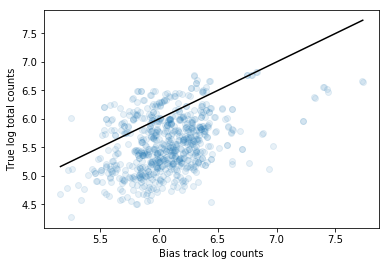

SpearmanrResult(correlation=0.3377331648916429, pvalue=1.0113392070928765e-20)


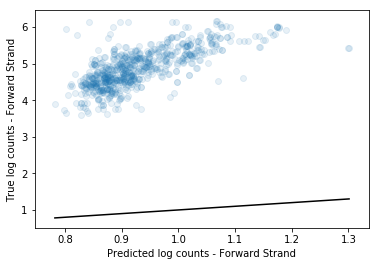

SpearmanrResult(correlation=0.7143120558028233, pvalue=1.0282651506132398e-113)


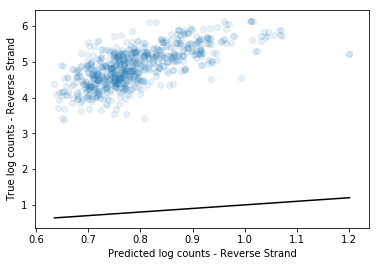

SpearmanrResult(correlation=0.6773344750794418, pvalue=4.525006524787115e-98)


In [86]:
from matplotlib import pyplot as plt
from scipy.stats import spearmanr

test_labels_logtotalcount = np.log(np.sum(np.exp(test_labels_logcount) - 1,axis=-1) + 1)

plt.scatter(test_biastrack_logcount, test_labels_logtotalcount, alpha=0.1)
plt.xlabel("Bias track log counts")
plt.ylabel("True log total counts")
plt.plot([np.min(test_biastrack_logcount), np.max(test_biastrack_logcount)],
         [np.min(test_biastrack_logcount), np.max(test_biastrack_logcount)],
         color="black")
plt.show()
print(spearmanr(test_biastrack_logcount, test_labels_logtotalcount))


#do a scatterplot of total count predictions
plt.scatter(test_preds_logcount[:,0], test_labels_logcount[:,0], alpha=0.1)
plt.xlabel("Predicted log counts - Forward Strand")
plt.ylabel("True log counts - Forward Strand")
plt.plot([np.min(test_preds_logcount[:,0]), np.max(test_preds_logcount[:,0])],
         [np.min(test_preds_logcount[:,0]), np.max(test_preds_logcount[:,0])],
         color="black")
plt.show()
print(spearmanr(test_preds_logcount[:,0], test_labels_logcount[:,0]))

plt.scatter(test_preds_logcount[:,1], test_labels_logcount[:,1], alpha=0.1)
plt.xlabel("Predicted log counts - Reverse Strand")
plt.ylabel("True log counts - Reverse Strand")
plt.plot([np.min(test_preds_logcount[:,1]), np.max(test_preds_logcount[:,1])],
         [np.min(test_preds_logcount[:,1]), np.max(test_preds_logcount[:,1])],
         color="black")
plt.show()
print(spearmanr(test_preds_logcount[:,1], test_labels_logcount[:,1]))

In [87]:
!pip install deeplift
from deeplift.util import compile_func

idx 239
Counts [467. 456.]
Predcounts [1.6867752 1.2616861]
oneovertemp 1.0
(1000, 2)
Pred profile shape (1000, 2)


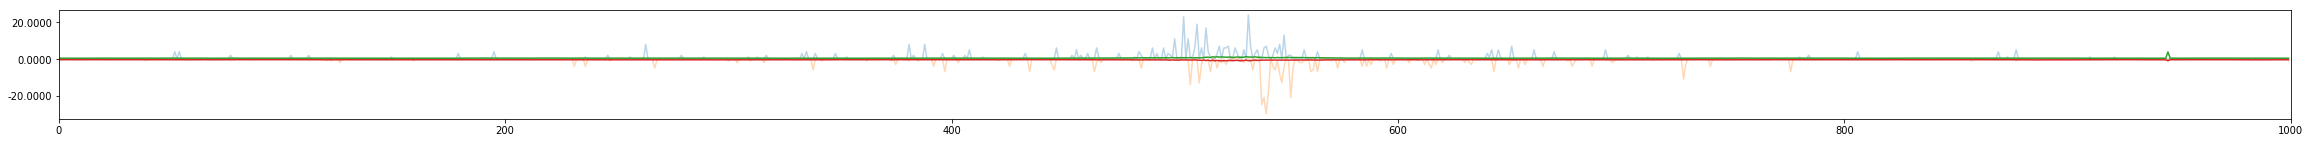

LOGITS


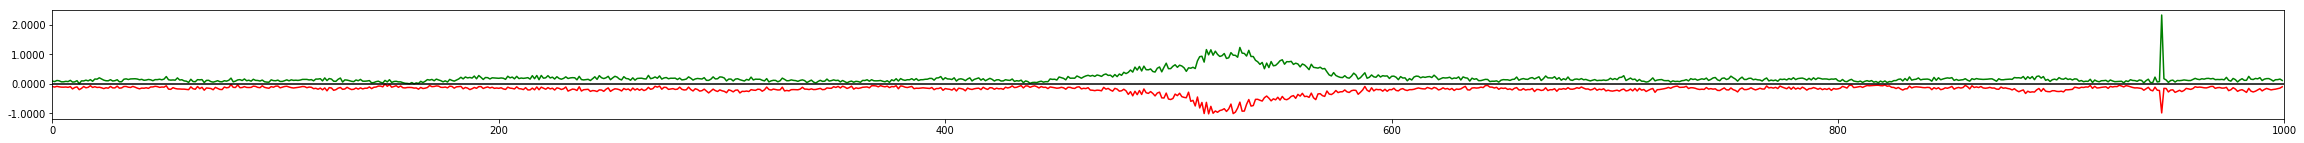

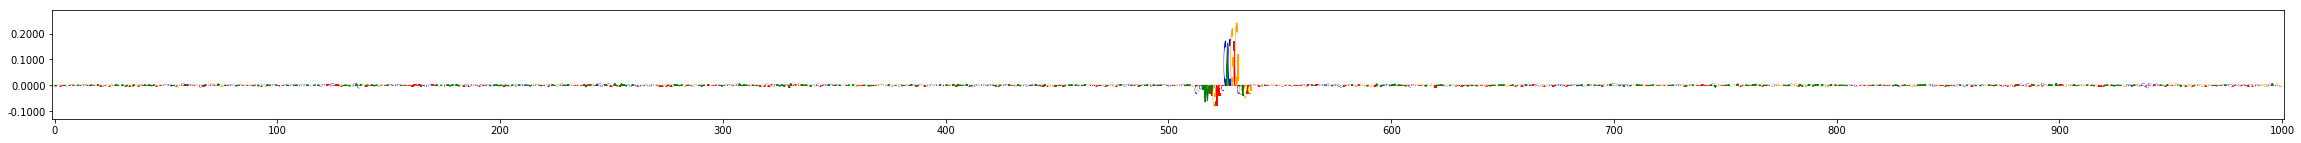

idx 240
Counts [461. 455.]
Predcounts [1.704678  1.2948384]
oneovertemp 1.0
(1000, 2)
Pred profile shape (1000, 2)


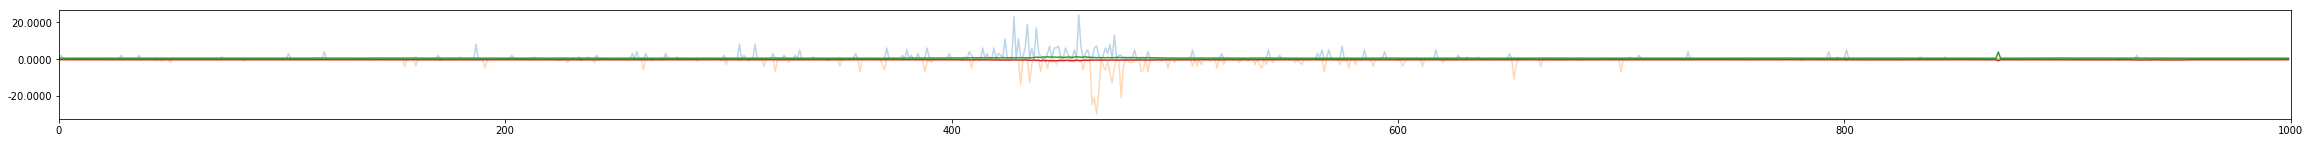

LOGITS


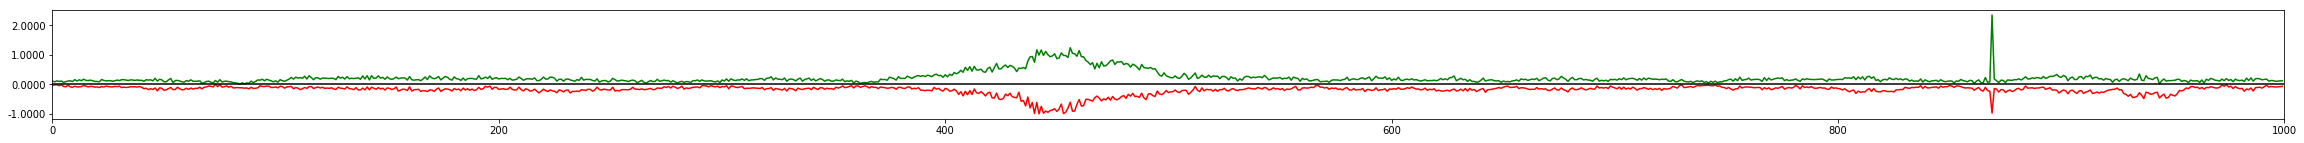

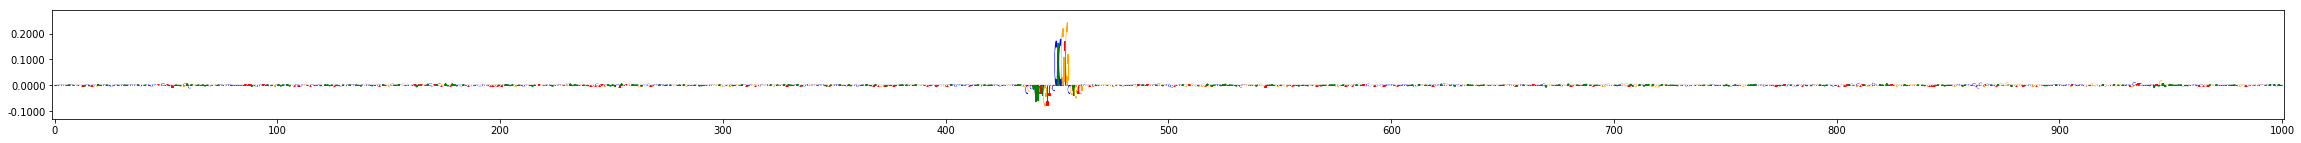

idx 92
Counts [412. 461.]
Predcounts [2.2339966 1.7521977]
oneovertemp 1.0
(1000, 2)
Pred profile shape (1000, 2)


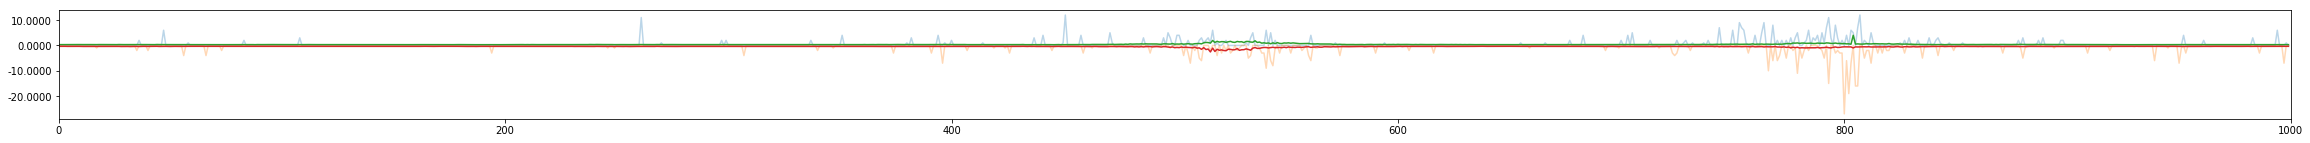

LOGITS


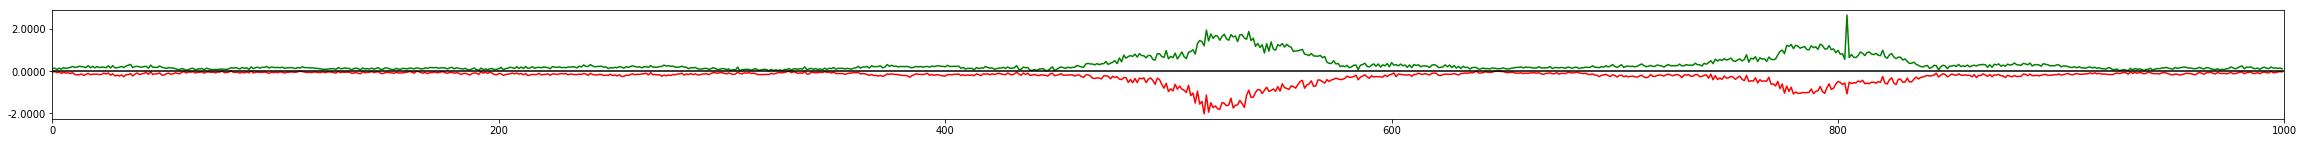

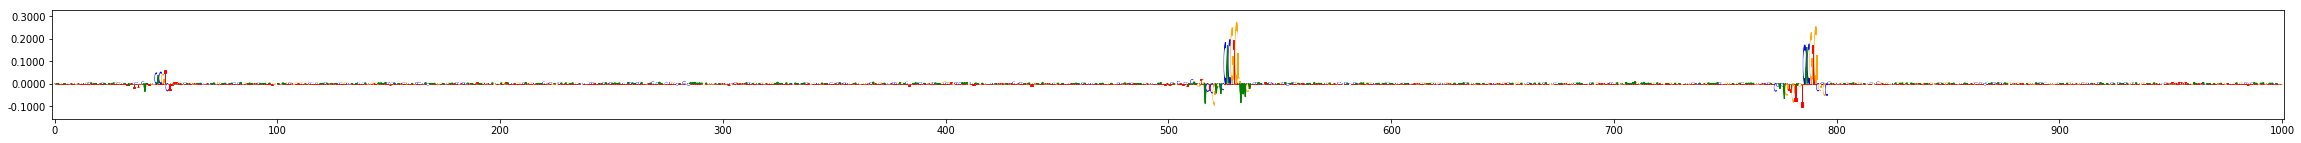

idx 91
Counts [408. 463.]
Predcounts [2.23603   1.7598486]
oneovertemp 1.0
(1000, 2)
Pred profile shape (1000, 2)


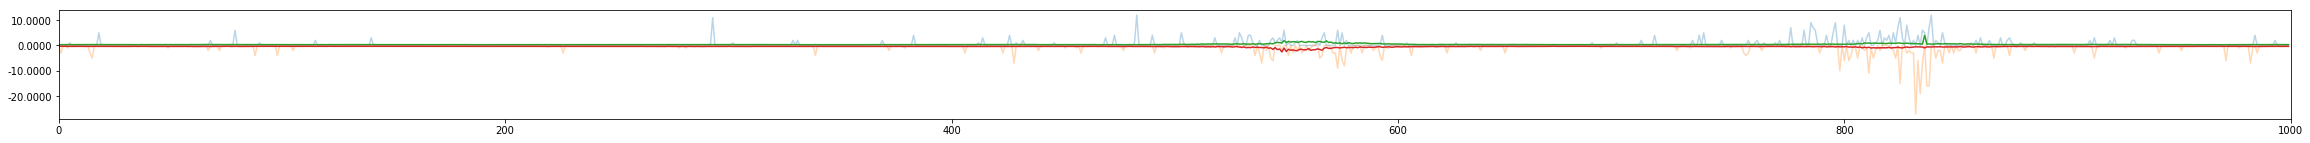

LOGITS


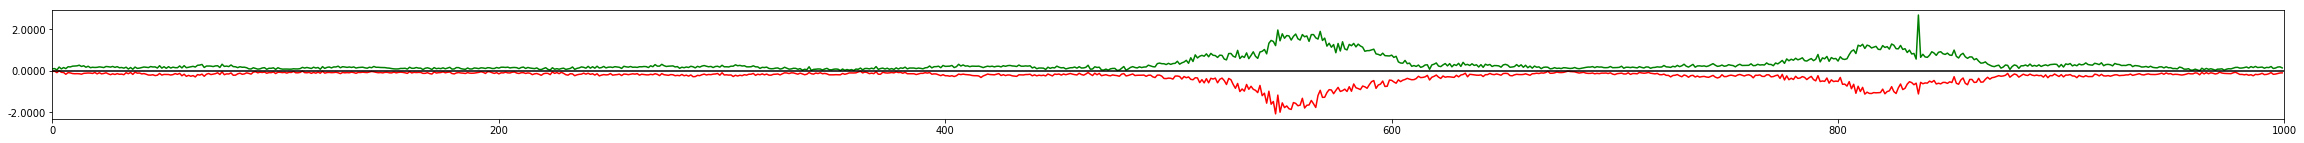

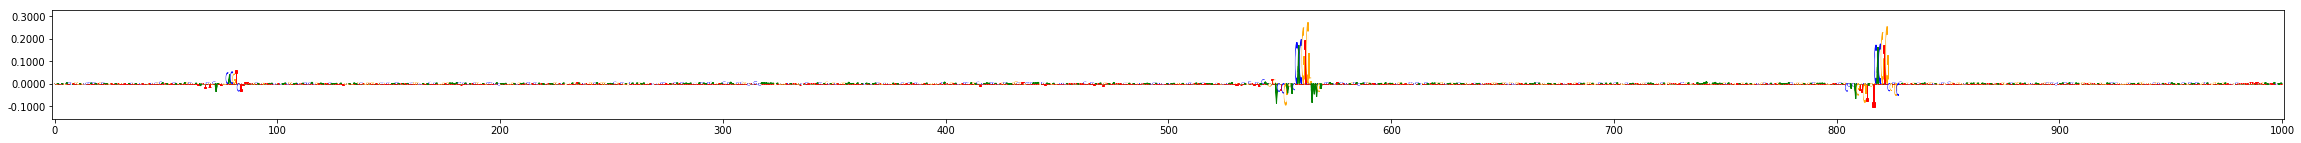

idx 93
Counts [401. 466.]
Predcounts [2.2348483 1.7459056]
oneovertemp 1.0
(1000, 2)
Pred profile shape (1000, 2)


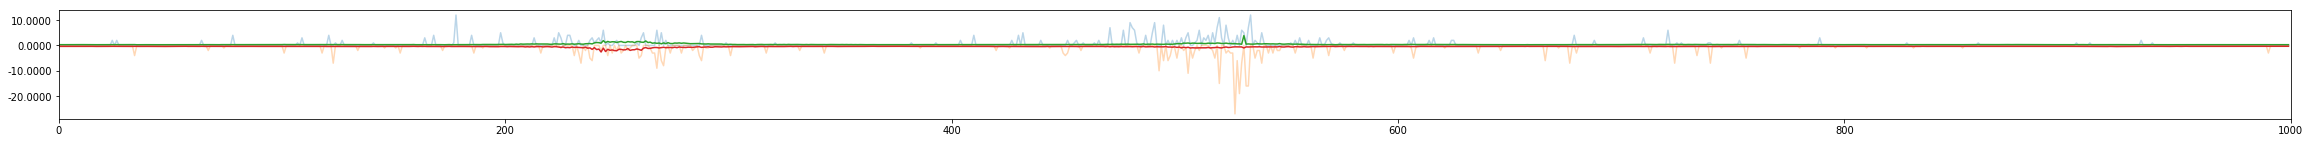

LOGITS


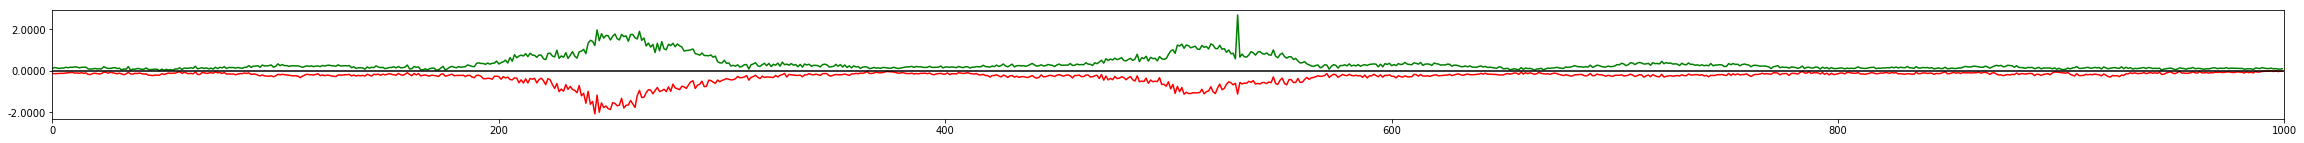

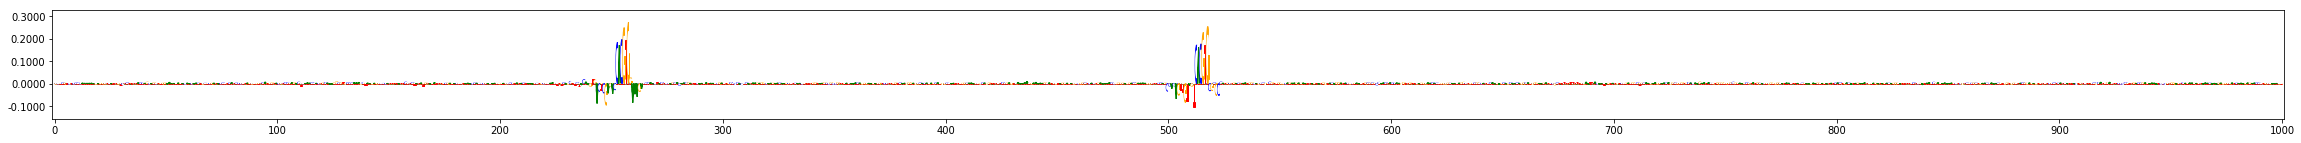

idx 94
Counts [401. 466.]
Predcounts [2.2345703 1.7502732]
oneovertemp 1.0
(1000, 2)
Pred profile shape (1000, 2)


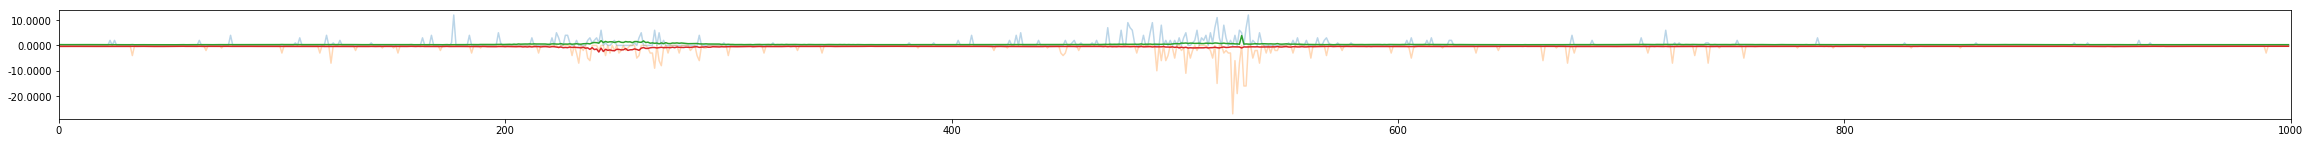

LOGITS


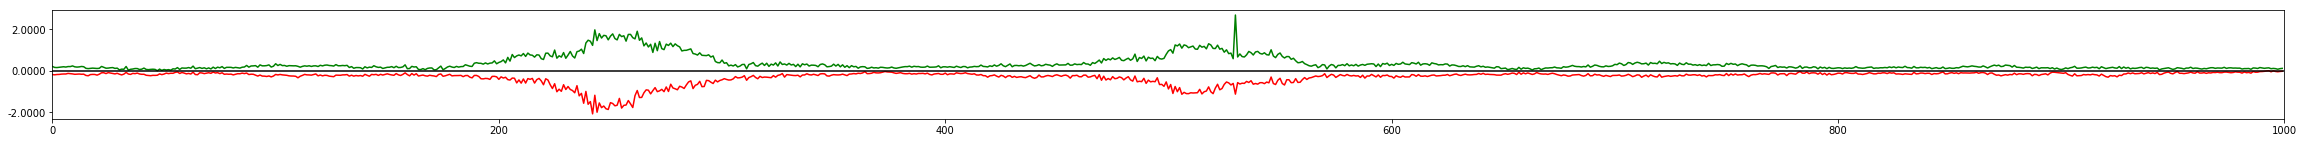

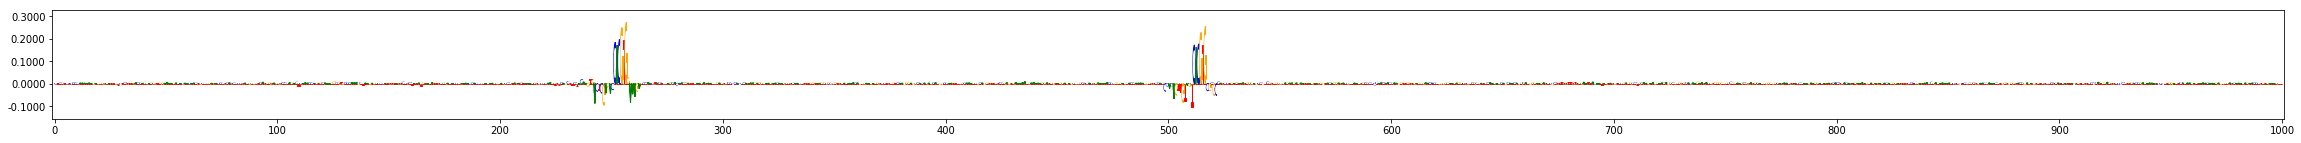

idx 172
Counts [436. 429.]
Predcounts [1.9246981 1.6391828]
oneovertemp 1.0
(1000, 2)
Pred profile shape (1000, 2)


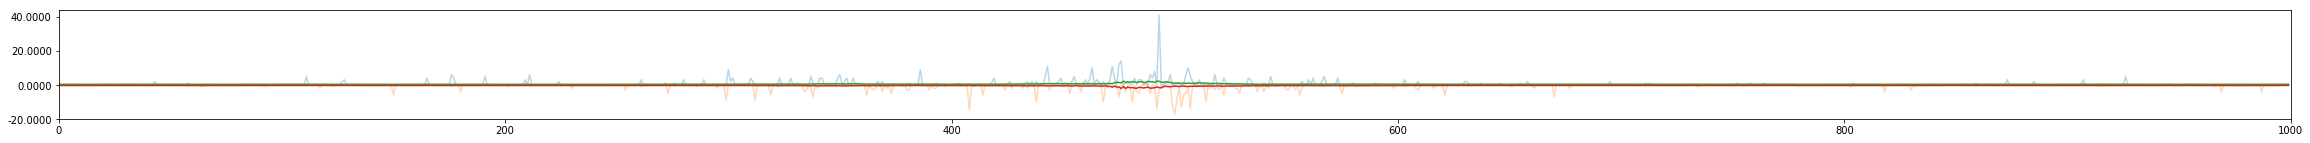

LOGITS


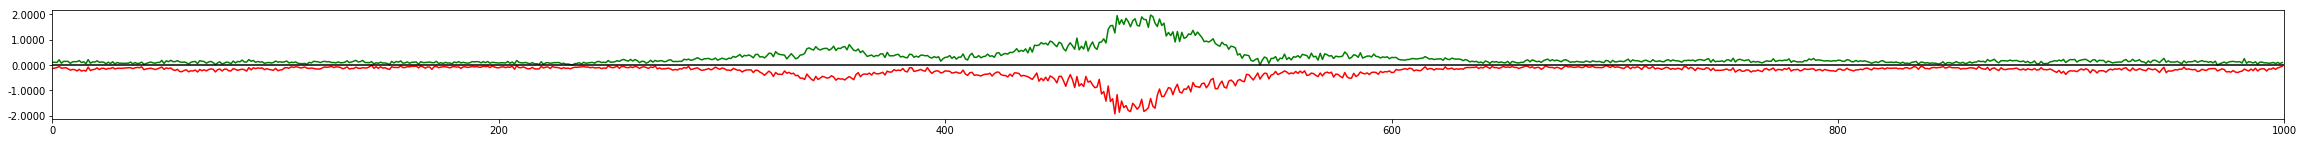

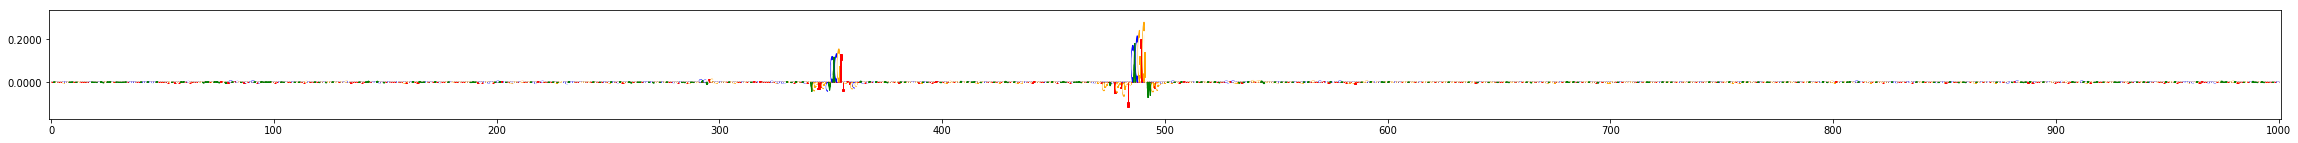

idx 171
Counts [436. 425.]
Predcounts [1.9030726 1.6216712]
oneovertemp 1.0
(1000, 2)
Pred profile shape (1000, 2)


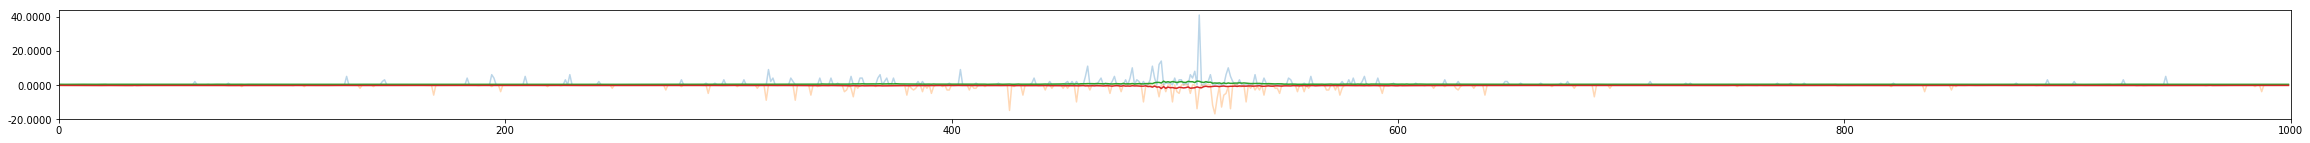

LOGITS


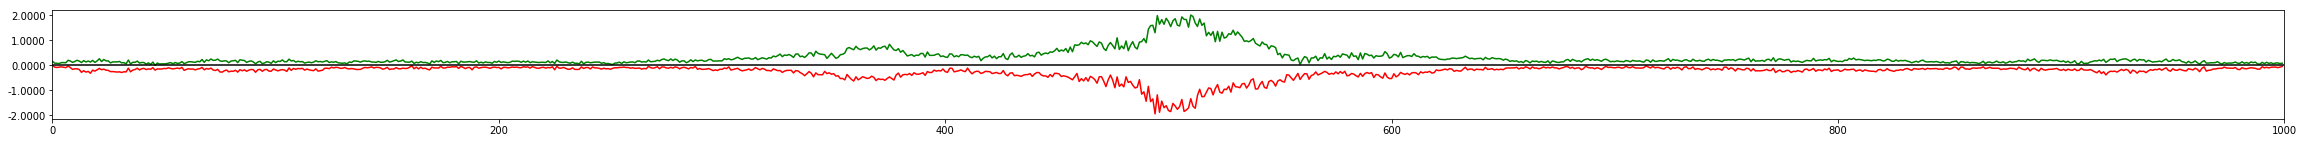

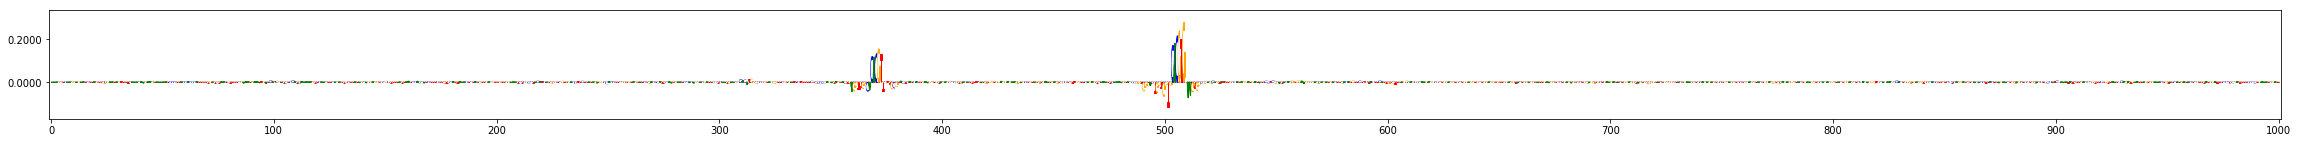

idx 128
Counts [333. 463.]
Predcounts [1.8782156 1.6106472]
oneovertemp 1.0
(1000, 2)
Pred profile shape (1000, 2)


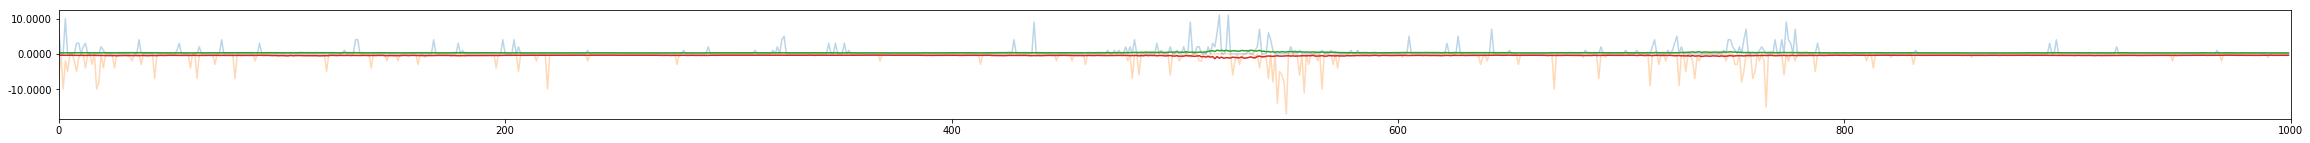

LOGITS


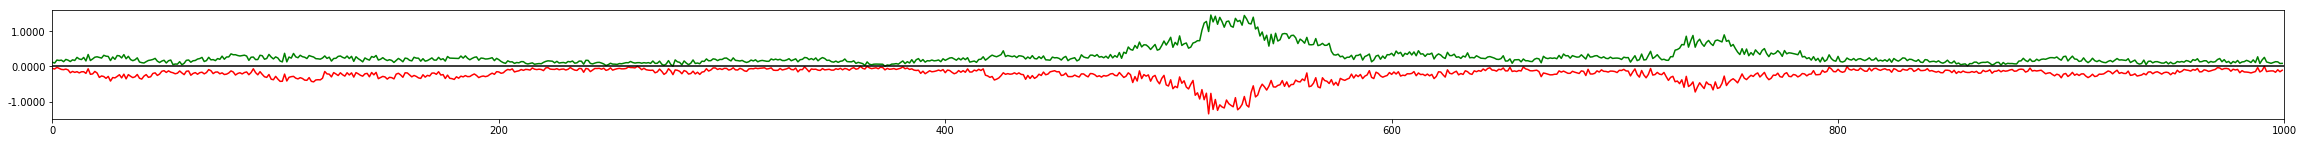

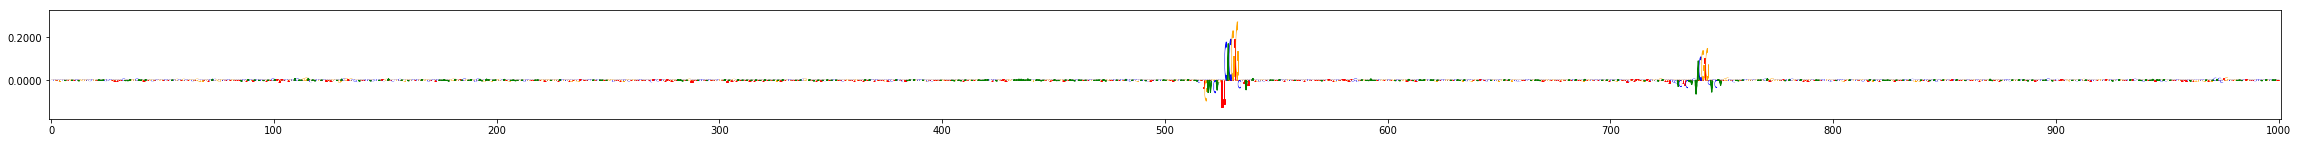

idx 342
Counts [479. 308.]
Predcounts [1.9107461 1.6579499]
oneovertemp 1.0
(1000, 2)
Pred profile shape (1000, 2)


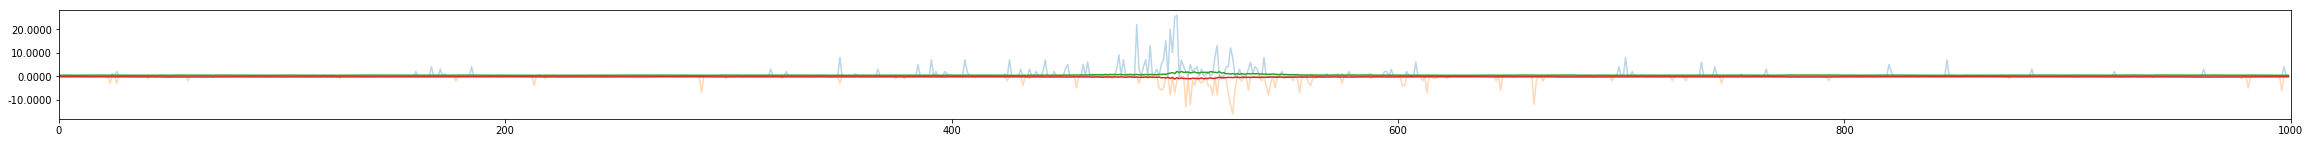

LOGITS


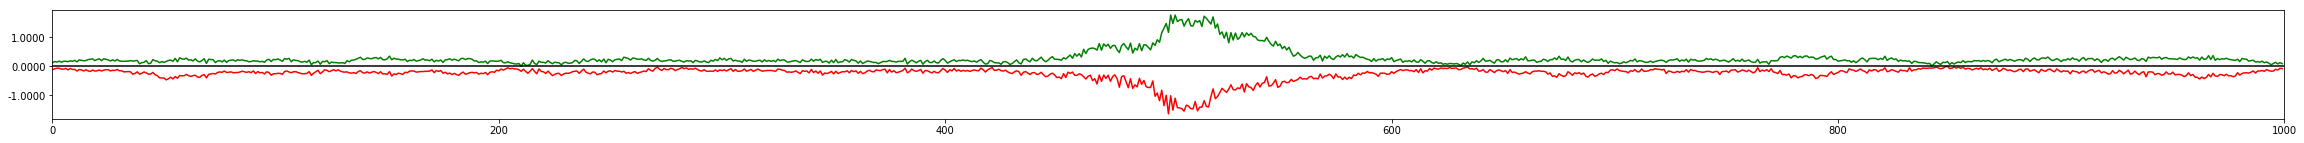

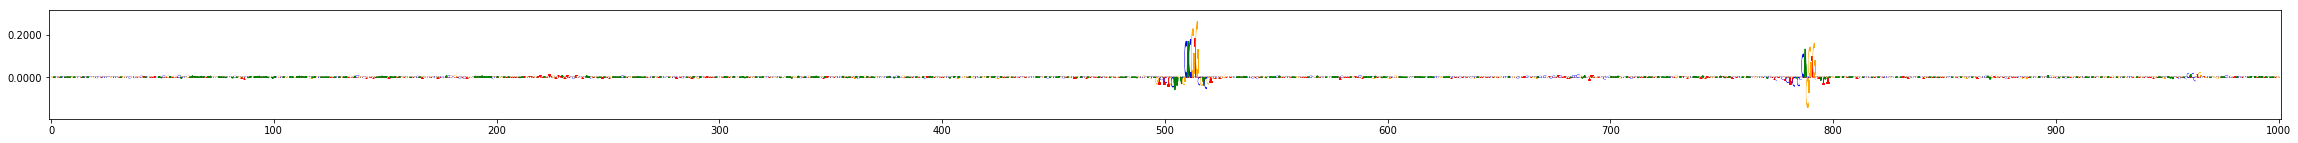

In [88]:
from deeplift.visualization import viz_sequence
from matplotlib.ticker import FormatStrFormatter

gradtensor = tf.gradients(ys=tf.reduce_sum(model.outputs[0],1),
                          xs=model.inputs[0])[0]
gradfunc = compile_func(inputs=model.inputs, outputs=gradtensor)

sorted_test_indices = [x[0] for x in 
                       sorted(enumerate(test_labels_logtotalcount),
                              key=lambda x: -x[1])]

def smooth(vals):
  return np.convolve(vals, np.ones(1,)/1, mode='same')

for idx in sorted_test_indices[:10]: 
  true_profile = test_labels_profile[idx] 
  print("idx",idx)
  print("Counts",np.sum(true_profile,axis=0) )
  print("Predcounts",np.exp(test_preds_logcount[idx])-1)

  for oneovertemp in [1.0]:
      print("oneovertemp",oneovertemp)
      print(test_labels_profile[idx].shape)
      print("Pred profile shape", test_preds_profile[idx].shape)
      pred_profile = (np.sum(test_labels_profile[idx], axis=0)[None,:] #total counts
                      *(np.exp(test_preds_profile[idx]*oneovertemp)/
                        np.sum(np.exp(test_preds_profile[idx]*oneovertemp),axis=0)[None,:]) )   
      plt.figure(figsize=(40,2))
      plt.plot(np.arange(len(true_profile)), smooth(true_profile[:,0]), alpha=0.3)
      plt.plot(np.arange(len(true_profile)), -smooth(true_profile[:,1]), alpha=0.3)
      plt.plot(np.arange(len(pred_profile)), pred_profile[:,0])
      plt.plot(np.arange(len(pred_profile)), -pred_profile[:,1])
      plt.xlim(0,1000)
      plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
      plt.show()

  print("LOGITS")
  pred_profile_logits = (test_preds_profile[idx])
  plt.figure(figsize=(40,2))
  plt.plot(np.arange(len(pred_profile)), pred_profile_logits[:,0] - np.min(pred_profile_logits[:,0]),color="green")
  plt.plot(np.arange(len(pred_profile)), -(pred_profile_logits[:,1] - np.min(pred_profile_logits[:,1])),color="red")
  plt.plot([0,1000],[0,0],color="black")
  plt.xlim(0,1000)
  plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
  plt.show()

      
  seqs_to_explain = test_seqs[idx:idx+1]
  control_logcounts = test_biastrack_logcount[idx:idx+1][:,None]
  control_profiles = test_biastrack_profile[idx:idx+1]

  explanation = gradfunc([seqs_to_explain,
                          control_logcounts,
                          control_profiles])*seqs_to_explain
  plt.figure(figsize=(40,2))
  plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
  viz_sequence.plot_weights_given_ax(ax=plt.gca(),
                                     array=explanation[0],
                                     height_padding_factor=0.2,
                                     length_padding=1.0,
                                     highlight={},
                                     subticks_frequency=100)
  plt.show()

In [89]:
!pip install pyBigWig
import pyBigWig

In [0]:
!touch neg_count_preds.bw

In [0]:
!touch pos_logits.bw
!touch neg_logits.bw

In [0]:
!touch pos_count_preds.bw
!touch neg_count_preds.bw

In [0]:
pos_bw = pyBigWig.open("pos_logits.bw","w")
neg_bw = pyBigWig.open("neg_logits.bw","w")

In [0]:
p_count_bw = pyBigWig.open("pos_count_preds.bw","w")
n_count_bw = pyBigWig.open("neg_count_preds.bw","w")

In [0]:
pos_bw.addHeader([("chrX",745751),("chrXI",666816)])
neg_bw.addHeader([("chrX",745751),("chrXI",666816)])

In [0]:
p_count_bw.addHeader([("chrX",745751),("chrXI",666816)])
n_count_bw.addHeader([("chrX",745751),("chrXI",666816)])

In [0]:
# store pos and neg count predictions into np array
pos_counts = []
neg_counts = []
for idx in range(len(test_preds_profile)):
  pred_profile = (np.sum(test_labels_profile[idx], axis=0)[None,:] #total counts
                      *(np.exp(test_preds_profile[idx])/
                        np.sum(np.exp(test_preds_profile[idx]),axis=0)[None,:]) )
  pos_counts.append(pred_profile[:,0])
  neg_counts.append(-pred_profile[:,1])
  
p_counts = np.array(pos_counts)
n_counts = np.array(neg_counts)

In [0]:
#normalize logits.
pos_logits = []
neg_logits = []
for idx in range(len(test_preds_profile)):
  pos_logits.append(test_preds_profile[idx][:,0]-np.min(test_preds_profile[idx][:,0]))
  neg_logits.append(-(test_preds_profile[idx][:,1]-np.min(test_preds_profile[idx][:,1])))
p_logits = np.array(pos_logits);
n_logits = np.array(neg_logits);

In [0]:
#chrom number, chrom start, chrom end.
chrom_num = []
chrom_start = []
chrom_end = []

test_data = keras_test_batch_generator.coordsbatch_producer._read_bed_file(bed_file="test_1k_around_summits.bed.gz")

for idx in range(len(test_data)):
  chrom_num.append(test_data[idx].chrom)
  chrom_start.append(test_data[idx].start)
  chrom_end.append(test_data[idx].end)
  
c_num = np.array(chrom_num);
c_start = np.array(chrom_start);
c_end = np.array(chrom_end);

In [0]:
#take care of overlaps
pos_logs_dict = {}
neg_logs_dict = {}
pos_counts_dict = {}
neg_counts_dict = {}
for i in range(len(c_num)):
  for n in range(c_start[i],c_end[i]):
    pos_logs_dict[c_num[i]+str(n)] = p_logits[i][n-c_start[i]]
    neg_logs_dict[c_num[i]+str(n)] = n_logits[i][n-c_start[i]]
    
    pos_counts_dict[c_num[i]+str(n)] = p_counts[i][n-c_start[i]]
    neg_counts_dict[c_num[i]+str(n)] = n_counts[i][n-c_start[i]]

  if (i<len(c_num)-1 and c_num[i]==c_num[i+1] and c_end[i]>c_start[i+1]):
    for j in range(c_start[i+1],c_end[i]):
      count=0
      pos_logs_dict[c_num[i]+str(j)] = max(p_logits[i+1][count],pos_logs_dict[c_num[i]+str(j)])
      neg_logs_dict[c_num[i]+str(j)] = min(n_logits[i+1][count],neg_logs_dict[c_num[i]+str(j)])

      pos_counts_dict[c_num[i]+str(j)] = max(p_counts[i+1][count],pos_counts_dict[c_num[i]+str(j)])
      neg_counts_dict[c_num[i]+str(j)] = min(n_counts[i+1][count],neg_counts_dict[c_num[i]+str(j)])
      
      count=count+1

In [0]:
from itertools import *

In [0]:
ch_num = []
ch_start = []
ch_end = []
p_log = []
n_log = []
p_count = []
n_count = []
for pos_entry in pos_logs_dict:
  chrom_number = "".join(takewhile(str.isalpha,pos_entry))
  ch_num.append(chrom_number)
  pos_start = pos_entry.replace(chrom_number,"")
  ch_start.append(int(pos_start))
  ch_end.append(int(pos_start)+1)
  p_log.append(pos_logs_dict[pos_entry])
  n_log.append(neg_logs_dict[pos_entry])
  p_count.append(pos_counts_dict[pos_entry])
  n_count.append(neg_counts_dict[pos_entry])
  
chr_num = np.array(ch_num)
chr_start = np.array(ch_start)
chr_end = np.array(ch_end)
pos_log = np.array(p_log)
neg_log = np.array(n_log)
pos_count = np.array(p_count)
neg_count = np.array(n_count)

In [0]:
pos_bw.addEntries(chr_num,chr_start,ends=chr_end,values=pos_log)

In [0]:
neg_bw.addEntries(chr_num,chr_start,ends=chr_end,values=neg_log)

In [0]:
p_count_bw.addEntries(chr_num,chr_start,ends=chr_end,values=pos_count)

In [0]:
n_count_bw.addEntries(chr_num,chr_start,ends=chr_end,values=neg_count)

In [109]:
!du -h pos_count_preds.bw

2.4M	pos_count_preds.bw


In [0]:
pos_bw.close()

In [0]:
neg_bw.close()

In [0]:
p_count_bw.close()

In [0]:
n_count_bw.close()

In [0]:
n_logits_bw = pyBigWig.open("neg_logits.bw",'r')

In [0]:
p_logits_bw = pyBigWig.open("pos_logits.bw",'r')

In [0]:
neg_count_bw = pyBigWig.open("neg_count_preds.bw",'r')

In [0]:
pos_count_bw = pyBigWig.open("pos_count_preds.bw",'r')

In [0]:
neg_count_bw.intervals("chrX");

In [253]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
root_path = 'gdrive/My Drive/Colab Notebooks/'  #change dir to your project folder